In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1" # NVIDIA GeForce RTX 3090
os.environ["CUDA_VISIBLE_DEVICES"]="6" # NVIDIA GeForce RTX 2080
 
import tensorflow.compat.v2 as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
 
print(gpus)

2024-03-12 14:28:57.860902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 14:28:58.175740: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 14:28:59.626501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/Anaconda3/envs/kiwibes_clone/lib/:/opt/Anaconda3/envs/kiwibes_clone/lib/
2024-03-12 14:28:59.626769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'l

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as layers
import zipfile
import os
import random
import datetime
import h5py
import cv2

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
# Clear any logs from previous runs
#!rm -rf ./logs/

/bin/bash: /opt/Anaconda3/envs/kiwibes_clone/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [5]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Data exploration

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
zip_ref = zipfile.ZipFile('Data/TRAIN_(1344x1024)_1.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('Data') #Extracts the files into the Data folder
zip_ref.close()

In [6]:
with open('Data/TRAIN_Images(1344x1024)_1.pkl', 'rb') as file:
    train_images = pickle.load(file)

with open('Data/TRAIN_Labels(1344x1024)_1.pkl', 'rb') as file:
    train_labels = pickle.load(file)

In [7]:
p0_p = np.mean([np.sum(train_labels[i]>0.05)/np.sum(train_labels[i]==0) for i in range(len(train_labels))])*100
p0_ptotal = np.mean([np.sum(train_labels[i]>0.05)/(512*672) for i in range(len(train_labels))])*100
print("The ratio of pixels with a value > 0.05 to pixels with a value = 0 is:",np.round(p0_p,2))
print(np.round(p0_ptotal,2), "percent of the pixels has a value bigger than 0.05.")

The ratio of pixels with a value > 0.05 to pixels with a value = 0 is: 0.53
1.9 percent of the pixels has a value bigger than 0.05.


## Dimensions

In [8]:
print(train_images.dtype)
print(train_labels.dtype)

float32
float32


In [9]:
print("The train set contains", str(len(train_images)), "images.")
print("The train set contains", str(len(train_labels)), "labels.")

The train set contains 436 images.
The train set contains 436 labels.


In [10]:
print("The images in the train set have a width of", str( train_images.shape[2]),"and a height of",str(train_images.shape[1]))
print("The labels in the train set have a width of", str( train_labels.shape[2]),"and a height of",str(train_labels.shape[1]))

The images in the train set have a width of 1344 and a height of 1024
The labels in the train set have a width of 1344 and a height of 1024


In [11]:
print("The maximum pixel value of the images is:", str(np.amax(train_images)))
print("The minumum pixel value of the images is:", str(np.amin(train_images)))

print("The maximum pixel value of the labels is:", str(np.amax(train_labels)))
print("The minumum pixel value of the labels is:", str(np.amin(train_labels)))

The maximum pixel value of the images is: 1.0
The minumum pixel value of the images is: 0.0
The maximum pixel value of the labels is: 0.9999993
The minumum pixel value of the labels is: 0.0


## Replicates

In [12]:
for train_image in train_images:
  if sum(np.all(train_images == train_image, axis=(1,2)))>1:
    print("There is a replicate.")

KeyboardInterrupt: 

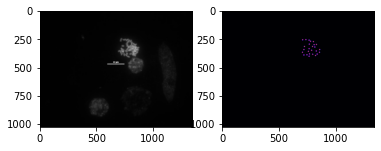

In [12]:
i = random.choice(range(len(train_images)))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_images[i],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(train_labels[i], cmap="inferno")

# Validation set and train set

In [13]:
n = int(0.3 * len(train_images))

train_features = train_images[n:]
train_targets = train_labels[n:]
val_features = train_images[:n]
val_targets = train_labels[:n]

In [14]:
print("The train set contains", str(len(train_features)), "images.")
print("The train set contains", str(len(train_targets)), "labels.")
print("The validation set contains", str(len(val_features)), "images.")
print("The validation set contains", str(len(val_targets)), "labels.")

The train set contains 306 images.
The train set contains 306 labels.
The validation set contains 130 images.
The validation set contains 130 labels.


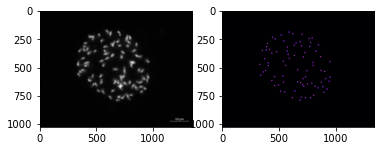

In [17]:
i = random.choice(range(len(train_features)))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(train_features[i],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(train_targets[i], cmap="inferno")

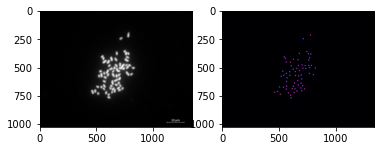

In [18]:
i = random.choice(range(len(val_features)))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(val_features[i],cmap="gray")
plt.subplot(1,2,2)
plt.imshow(val_targets[i], cmap="inferno")

# Data generator

In [19]:
# Create a HDF5 file for train set
fileHDFTrain = 'Data/train.hdf5'

with h5py.File(fileHDFTrain, 'w') as hdf:
    hdf.create_dataset('features', data=train_features)
    hdf.create_dataset('targets',  data=train_targets)
    
# Create a HDF5 file for validation set
fileHDFVal = 'Data/val.hdf5'

with h5py.File(fileHDFVal, 'w') as hdf:
    hdf.create_dataset('features', data=val_features)
    hdf.create_dataset('targets',  data=val_targets)

In [6]:
def create_hdf5_generator(
    db_path,
    batch_size,
    augmentations,
    keys = ['features', 'targets'],
    verbose = False
):
    
    """
    Same data augmentation on every instance in a batch.
    Some data augmentation methods (e.g. rotation) must be applied to both features and targets,
    others (e.g. brightness) only to the features.
    """

    db = h5py.File(db_path, 'r')
    db_size = db[keys[0]].shape[0] # size of dataset
    height = db[keys[0]].shape[1] 
    width = db[keys[0]].shape[2] 
    
    while True: 
        for b in np.arange(0, db_size, batch_size): #[0,4,8...]

            if keys == ['features', 'targets']:
                features = db['features'][b:b+batch_size].copy()
                targets = db['targets'][b:b+batch_size].copy()
            
            bs = features.shape[0]

            # Vertical flip
            if 'random_vertical_flip' in augmentations:
                if np.random.rand() > 0.5:
                    if verbose:
                        print('Vertical flip')
                    features = features[:,::-1,:]
                    targets  = targets[:,::-1,:]
                else:
                    if verbose:
                        print('No vertical flip')

            # Horizontal flip
            if 'random_horizontal_flip' in augmentations:
                if np.random.rand() > 0.5:
                    if verbose:
                        print('Horizontal flip')
                    features = features[:,:,::-1]
                    targets  = targets[:,:,::-1]
                else:
                    if verbose:
                        print('No horizontal flip')
                          
            # Translation
            if 'translation' in augmentations:
                
                translation_vertical   = int(random.uniform(-augmentations['translation'], augmentations['translation']))
                translation_horizontal = int(random.uniform(-augmentations['translation'], augmentations['translation']))
                
                if verbose:
                    print('Vertical translation:', translation_vertical)
                    print('Horizontal translation:', translation_horizontal)  
                    
                features = np.roll(np.roll(features, translation_vertical, axis = 1), translation_horizontal, axis = 2)
                targets = np.roll(np.roll(targets, translation_vertical, axis = 1), translation_horizontal, axis = 2)
                
            # Rotation
            if 'rotation' in augmentations:
                if augmentations['rotation'] > 0:
                    angle = 2*(random.random()-0.5)*augmentations['rotation']
                    if verbose:
                        print('Rotational angle:', angle)
                    M = cv2.getRotationMatrix2D((width//2, height//2), angle, 1.0)
                    features = np.array([cv2.warpAffine(features[i,:,:], M, (width, height)) for i in range(bs)])
                    targets = np.array([cv2.warpAffine(targets[i,:,:], M, (width, height)) for i in range(bs)])
                    # Suboptimal?
                    
            # Brightness
            if 'brightness' in augmentations:
                brightness = 2*(random.random()-0.5)*augmentations['brightness']
                if verbose:
                    print('Brightness:', brightness)
                features += brightness
                if brightness < 0:
                    features = np.maximum(features,0)
                elif brightness > 0:
                    features = np.minimum(features,1)

            # Channel shift: is the same as changing brightness for gray-scale images
            if 'channelshift' in augmentations:
                for c in range(len(augmentations['channelshift'])):
                    if augmentations['channelshift'][c] != 0:
                        channelshift = 2*(random.random()-0.5)*augmentations['channelshift'][c]
                        if verbose:
                            print('Channel shift:', c, channelshift)
                        features[:,:,:] += channelshift
                        if channelshift < 0:
                            features[:,:,:] = np.maximum(features[:,:,:],0)
                        elif channelshift > 0:
                            features[:,:,:] = np.minimum(features[:,:,:],1)
                            
            yield [features, targets]

In [7]:
batch_size = 4

augmentations = {
    'random_vertical_flip': None,
    'random_horizontal_flip': None,
    'rotation': 45,
    'translation': 500,
    'brightness': 0.2
}

fileHDFTrain = 'Data/train.hdf5'
fileHDFVal = 'Data/val.hdf5'

In [8]:
train_gen = create_hdf5_generator(
    fileHDFTrain,
    batch_size,
    augmentations = augmentations,
    keys = ['features', 'targets']
)

val_gen = create_hdf5_generator(
    fileHDFVal,
    batch_size,
    augmentations = {},
    keys = ['features', 'targets']
)

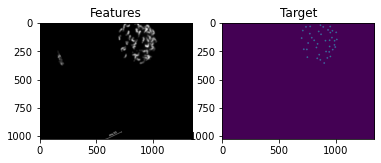

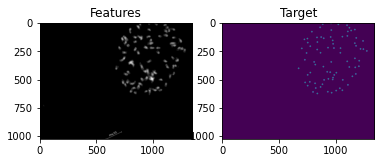

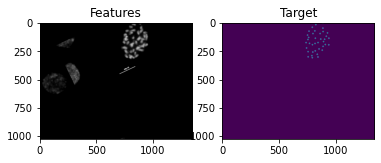

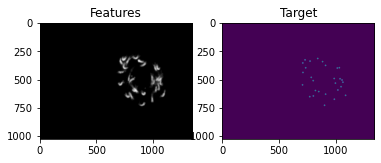

In [9]:
features, targets = next(train_gen)

for i in range(batch_size):
    plt.figure()
    plt.subplot(121)
    plt.imshow(features[i], cmap="gray")
    plt.title('Features')
    plt.subplot(122)
    plt.imshow(targets[i])
    plt.title('Target')
    plt.show()

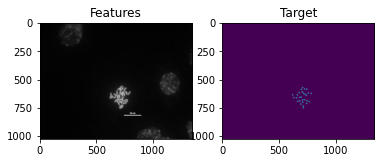

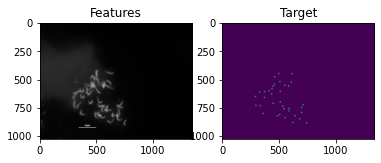

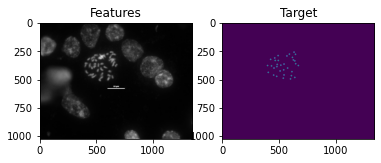

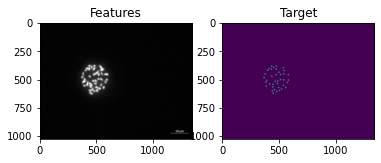

In [10]:
features, targets = next(val_gen)

for i in range(batch_size):
    plt.figure()
    plt.subplot(121)
    plt.imshow(features[i], cmap="gray")
    plt.title('Features')
    plt.subplot(122)
    plt.imshow(targets[i])
    plt.title('Target')
    plt.show()

# UNet


In [11]:
train = h5py.File(fileHDFTrain, 'r')
val = h5py.File(fileHDFVal, 'r')

In [12]:
h_img = train["features"].shape[1]
w_img = train["features"].shape[2]

In [13]:
# Calculate number of steps per epoch for train and validation
steps_per_epoch = len(train["features"])//batch_size
validation_steps = len(val["features"])//batch_size

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

steps_per_epoch: 76
validation_steps: 32


In [16]:
#data_augmentation = tf.keras.Sequential([
#    layers.RandomBrightness(factor=(-0.2,0.2)),
#    layers.RandomContrast(factor=0.2)])

2024-03-04 13:21:35.997714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 13:21:37.158944: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22297 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1e:00.0, compute capability: 8.6


In [14]:
# Make model

# inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
inputs = tf.keras.layers.Input((h_img, w_img, 1))

# Data-augmentation
#inputs = data_augmentation(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(r5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(u9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

2024-03-12 14:29:41.580851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 14:29:42.840937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9638 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:23:00.0, compute capability: 7.5


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1344,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1344,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1024, 1344,   2320        ['conv2d[0][0]']                 
                                16)                                                           

In [16]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics= [tf.keras.metrics.Precision(thresholds=0.1), tf.keras.metrics.Recall(thresholds=0.1)])

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir= log_dir),
        #tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_precision", mode='max', save_best_only=True)
]

In [17]:
model.fit(
    train_gen,
    validation_data=(val_gen),
    batch_size=batch_size,
    epochs=25,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/25


2024-03-12 14:29:54.664408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


76/76 [==============================] - 58s 610ms/step - loss: 0.2584 - precision: 0.0565 - recall: 0.7209 - val_loss: 0.3443 - val_precision: 0.0799 - val_recall: 0.9885
Epoch 2/25
76/76 [==============================] - 21s 282ms/step - loss: 0.0866 - precision: 0.0584 - recall: 0.1424 - val_loss: 0.1381 - val_precision: 0.0700 - val_recall: 0.7724
Epoch 3/25
76/76 [==============================] - 19s 256ms/step - loss: 0.0469 - precision: 0.2233 - recall: 0.0202 - val_loss: 0.0636 - val_precision: 0.2435 - val_recall: 0.0486
Epoch 4/25
76/76 [==============================] - 22s 285ms/step - loss: 0.0285 - precision: 0.6682 - recall: 0.0303 - val_loss: 0.0399 - val_precision: 0.7390 - val_recall: 0.0648
Epoch 5/25
76/76 [==============================] - 20s 260ms/step - loss: 0.0193 - precision: 0.8360 - recall: 0.0360 - val_loss: 0.0245 - val_precision: 0.8803 - val_recall: 0.0402
Epoch 6/25
76/76 [==============================] - 19s 256ms/step - loss: 0.0153 - precision: 0

In [18]:
history_dict = model.history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
prec = history_dict["precision"]
val_prec = history_dict["val_precision"]
recall = history_dict["recall"]
val_recall = history_dict["val_recall"]
epochs = range(1, len(loss_values) + 1)

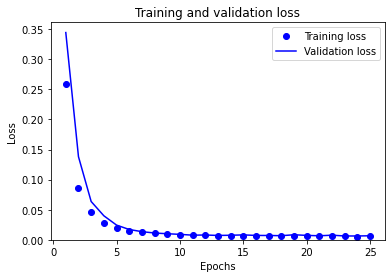

In [19]:
plt.figure()
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()
plt.show()

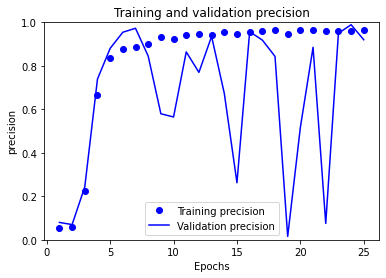

In [20]:
plt.plot(epochs, prec, "bo", label="Training precision")
plt.plot(epochs, val_prec, "b", label="Validation precision")
plt.title("Training and validation precision")
plt.xlabel("Epochs")
plt.ylabel("precision")
plt.ylim((0,1))
plt.legend()
plt.show()

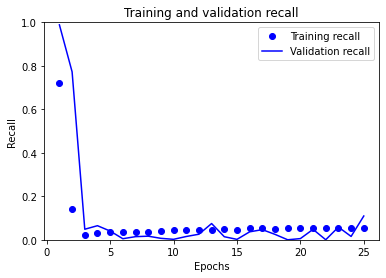

In [21]:
plt.plot(epochs, recall, "bo", label="Training recall")
plt.plot(epochs, val_recall, "b", label="Validation recall")
plt.title("Training and validation recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.ylim((0,1))
plt.legend()
plt.show()

In [22]:
val_prediction = model.predict(
    np.asarray(val["features"]),
    batch_size=batch_size)

33/33 [==============================] - 3s 60ms/step


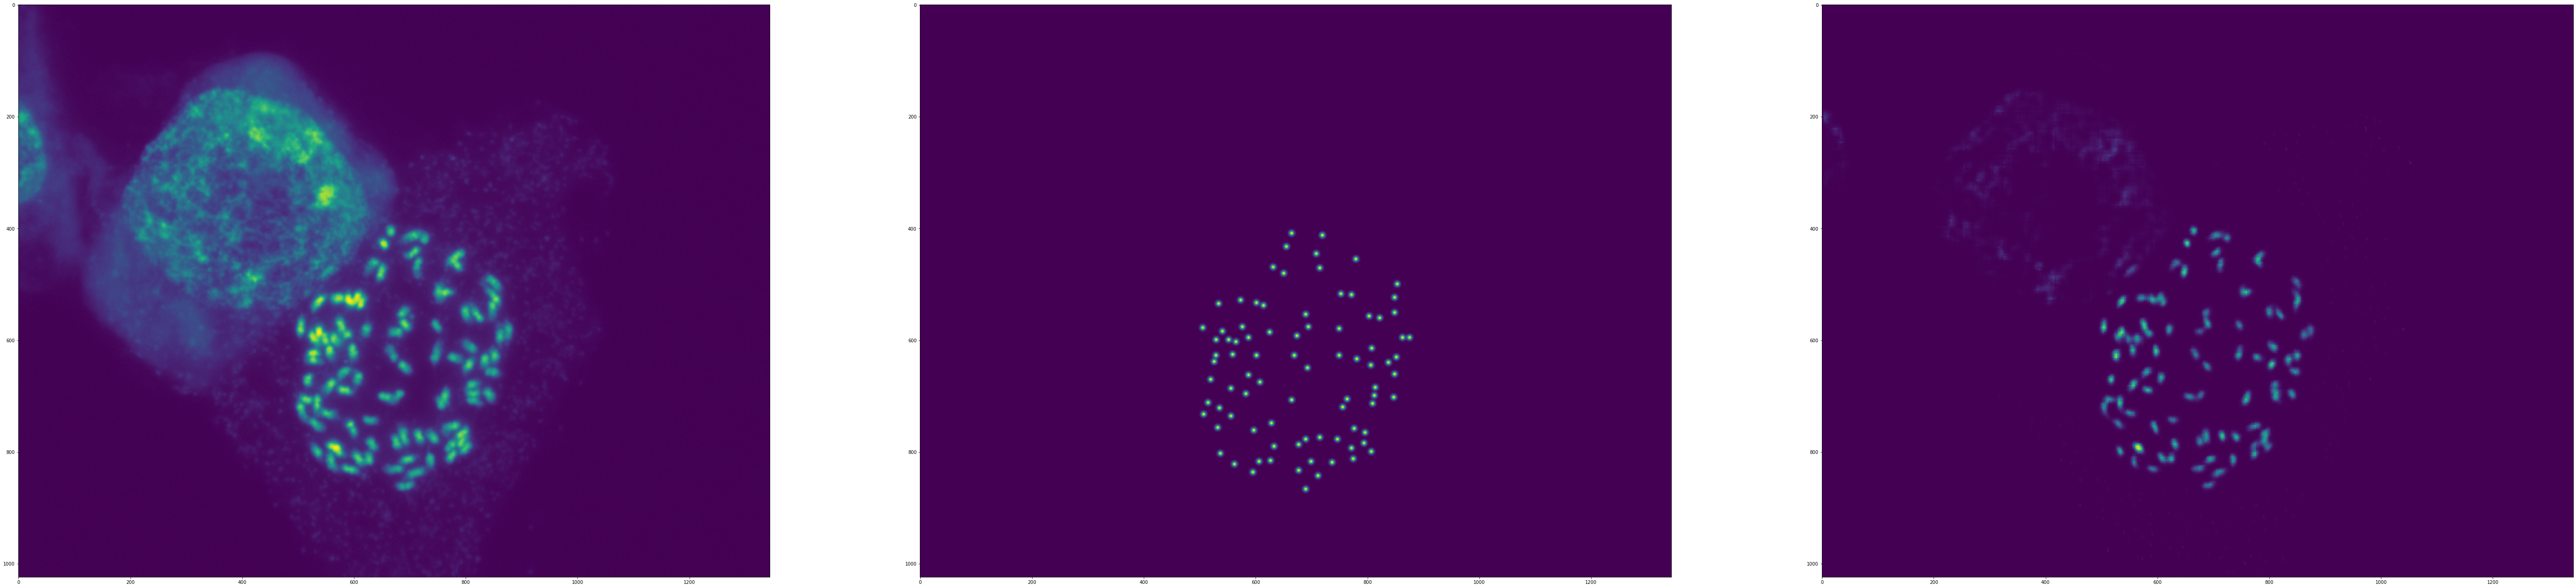

In [27]:
i = random.choice(range(len(val_prediction)))
plots = [val["features"][i], val["targets"][i], val_prediction[i]]

plt.figure(figsize=(100,75))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.imshow(plots[j])

Text(0.5, 1.0, 'Features')

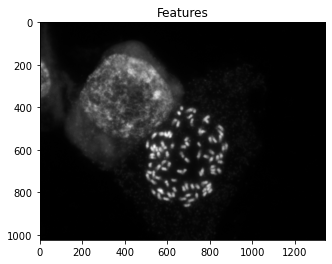

In [29]:
plt.imshow(val["features"][i], cmap="gray")
plt.title("Features")

Text(0.5, 1.0, 'Target')

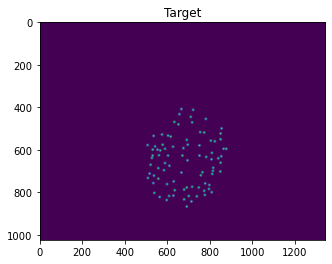

In [31]:
plt.imshow(val["targets"][i])
plt.title("Target")

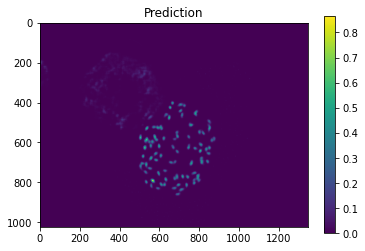

In [32]:
plt.imshow(val_prediction[i])
plt.title("Prediction")
plt.colorbar()

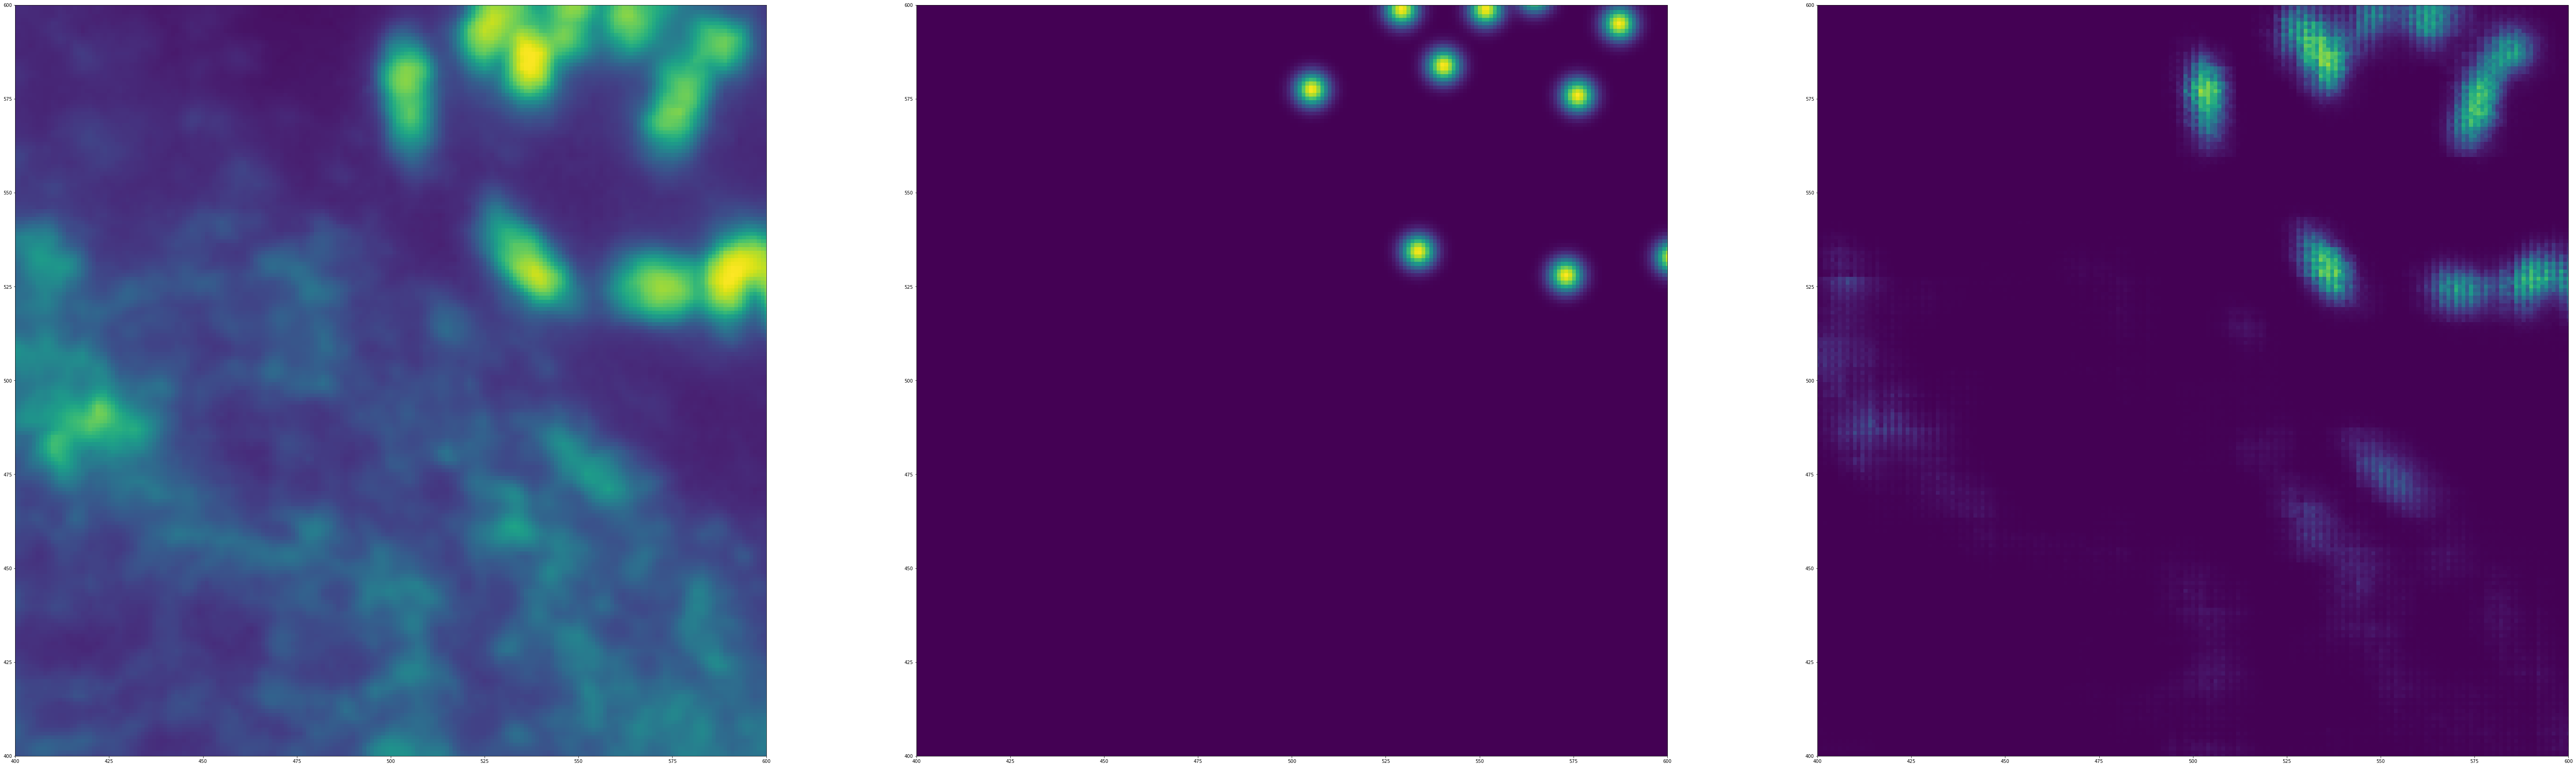

In [28]:
plots = [val["features"][i], val["targets"][i], val_prediction[i]]

plt.figure(figsize=(100,75))
for j in range(3):
    plt.subplot(1,3,j+1)
    plt.imshow(plots[j])
    plt.xlim([400,600])
    plt.ylim([400,600])

(600.0, 800.0)

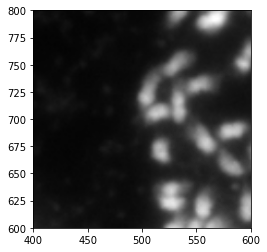

In [33]:
plt.figure()
plt.imshow(val["features"][i], cmap="gray")
plt.xlim([400,600])
plt.ylim([600,800])

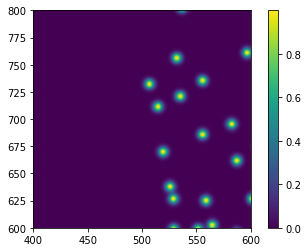

In [34]:
plt.figure()
plt.imshow(val["targets"][i])
plt.xlim([400,600])
plt.ylim([600,800])
plt.colorbar()

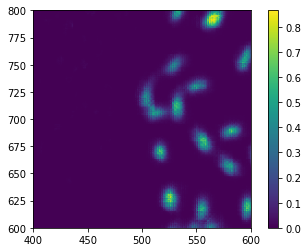

In [35]:
plt.figure()
plt.imshow(val_prediction[i])
plt.xlim([400,600])
plt.ylim([600,800])
plt.colorbar()

In [ ]:
%tensorboard --logdir "logs/"